In [39]:
import sys
import os
current_dir = os.getcwd()
sys.path.append(os.path.dirname(os.path.abspath(current_dir)))
from Grover.grover_num_list_cirq import find_num, find_num_list
from Backend.fake_backend import FakeBackend
from Backend.backend import Backend
from Backend.ibm_backend import IBM_backend

from Result.result import ResultData

from qiskit.visualization import plot_histogram, plot_coupling_map
from qiskit import transpile
import qiskit.providers.fake_provider
from qiskit_ibm_provider import IBMProvider
from qiskit.transpiler.passes import RemoveBarriers

from itertools import permutations

from SaveData.save_data_to_file import CSVWriter
import time
import random

In [30]:
draw_circuit = True

In [36]:
# Sample of Finding a number in a list Grover circuit
winner_list = [4]
num_array = [0, 5, 7, 8, 2, 4, 9, 10, 3, 2, 9, 0, 2, 3, 4, 5]
find_num_in_data = find_num_list()
find_num_in_data.build_iteration(winner_list=winner_list, num_array=num_array, block_diagram=False, default_value=0)
find_num_in_data.create_grover(num_solutions=1, prep_value=[], block_diagram=False)
cur_experiments = find_num_in_data.measure_qc
print(f"Number of Grover circuits : {len(cur_experiments)}")
print(f"Circuit Depth is : {cur_experiments[0].depth()}")
cur_experiments[0].draw('mpl') if draw_circuit else None

Number of Grover circuits : 1
Circuit Depth is : 356


Number of Grover circuits : 1
Circuit Depth is : 74


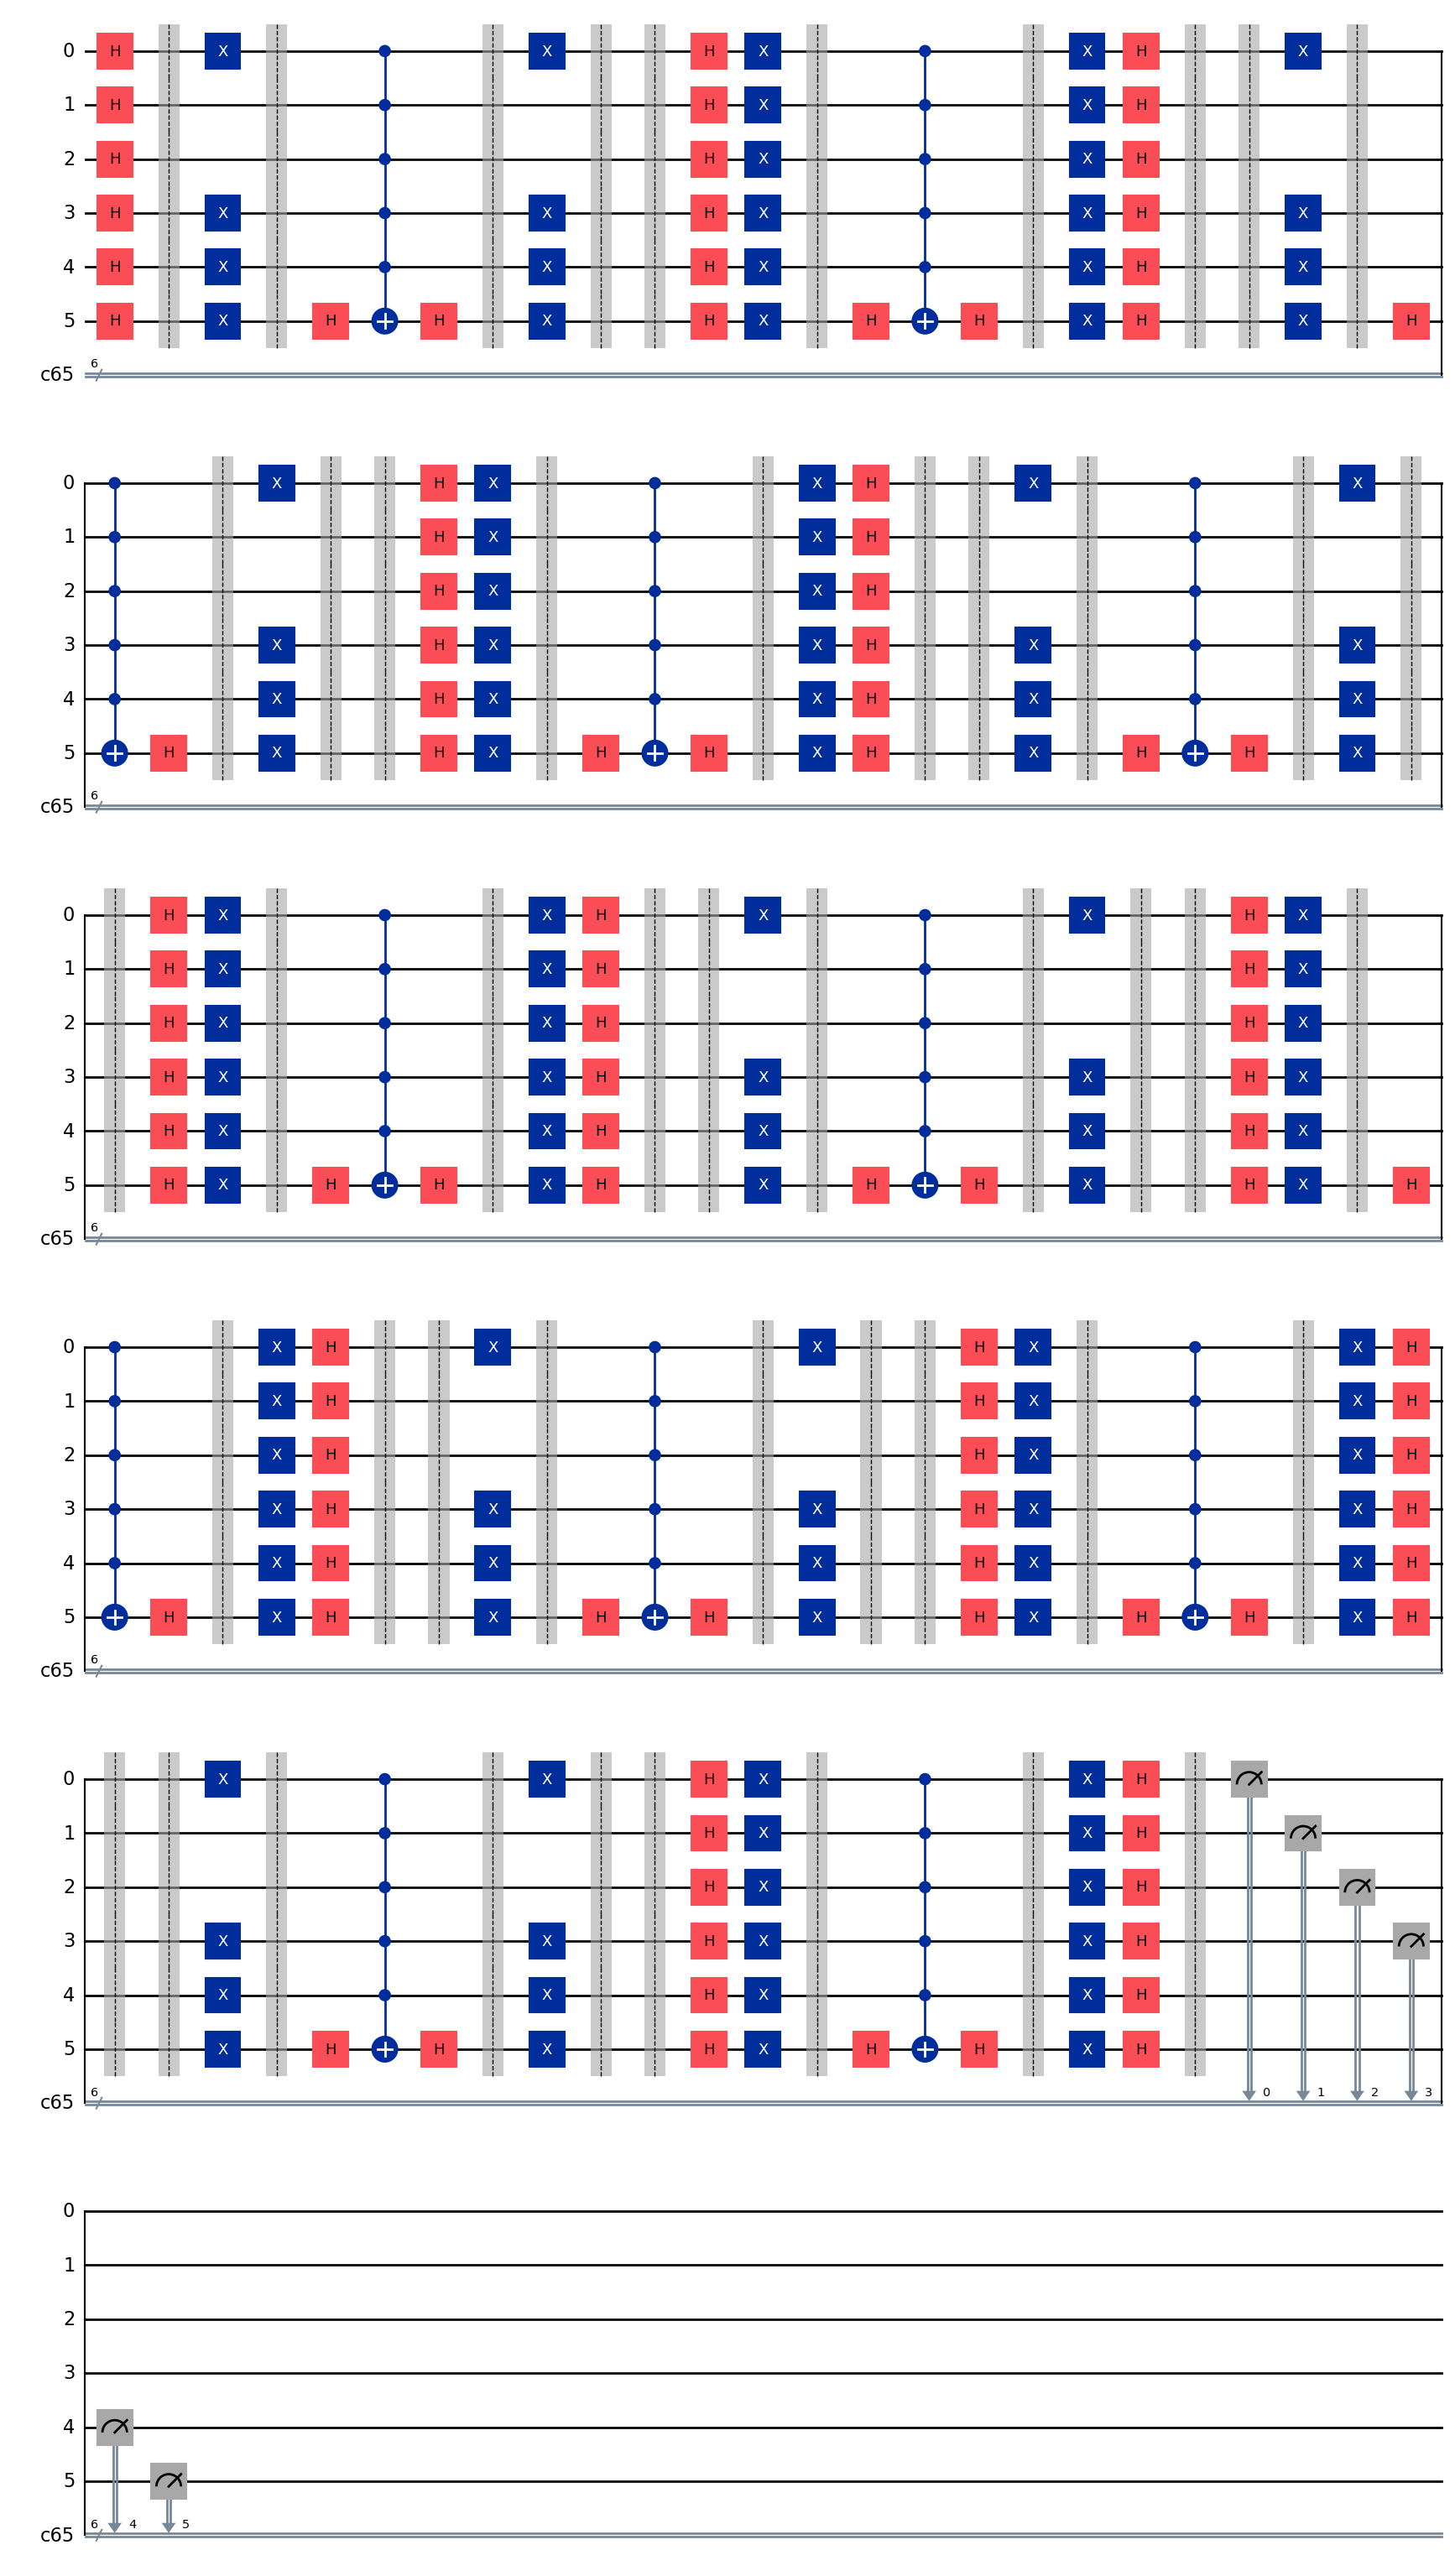

In [31]:
# Sample of Find Number Grover Circuit
find_num_in_world_obj =  find_num()
winner_list = [6]
num_array = []
find_num_in_world_obj.build_iteration(winner_num_list=[6], circuit_nqubits=6, block_diagram=False)
find_num_in_world_obj.create_grover(num_solutions=1, prep_value=[], block_diagram=False)
cur_experiments = find_num_in_world_obj.measure_qc
print(f"Number of Grover circuits : {len(cur_experiments)}")
print(f"Circuit Depth is : {cur_experiments[0].depth()}")
cur_experiments[0].draw('mpl') if draw_circuit else None

In [ ]:
# Getting the Fake backend List
FakeBackend.get_ibm_fake_backend_name_list()

In [3]:
# Getting the Fake backend List with qubit limits
FakeBackend.get_ibm_fake_backend_names_with_limit(20, 30)

['fake_algiers',
 'fake_almaden',
 'fake_auckland',
 'fake_boeblingen',
 'fake_cairo',
 'fake_cambridge',
 'fake_geneva',
 'fake_hanoi',
 'fake_johannesburg',
 'fake_kolkata',
 'fake_montreal',
 'fake_mumbai',
 'fake_paris',
 'fake_peekskill',
 'fake_poughkeepsie',
 'fake_singapore',
 'fake_sydney',
 'fake_toronto']

In [14]:
# Get Fake Backend by name
FakeBackend.get_ibm_fake_backend('fake_auckland')

In [145]:
aer_backend = Backend()

In [146]:
# Using qiskit Transpile with optimaztion level 0 = No opt
transpiled_circuit_aer_opt_0 = transpile(cur_experiments[0], aer_backend.get_backend(), optimization_level=0)
print(f"Trasnpiled circuit depth : {transpiled_circuit_aer_opt_0.depth()}")
transpiled_circuit_aer_opt_0.draw('mpl') if draw_circuit else None

Trasnpiled circuit depth : 128052


In [147]:
# Using qiskit Transpile with optimaztion level 3 = Max opt
transpiled_circuit_aer_opt_3 = transpile(cur_experiments[0], aer_backend.get_backend(), optimization_level=3)
print(f"Trasnpiled circuit depth : {transpiled_circuit_aer_opt_3.depth()}")
transpiled_circuit_aer_opt_3.draw('mpl') if draw_circuit else None

Trasnpiled circuit depth : 127852


In [ ]:
aer_job = aer_backend.run(transpiled_circuit_aer_opt_0)
aer_res = ResultData(aer_job)
print(aer_res.get_result_time_taken())
plot_histogram(aer_res.get_counts())

In [ ]:
aer_job = aer_backend.run(transpiled_circuit_aer_opt_3)
aer_res = ResultData(aer_job)
print(aer_res.get_result_time_taken())
plot_histogram(aer_res.get_counts())

In [122]:
generic_backend = Backend(num_qubits=len(cur_experiments[0].qubits))

In [26]:
# Using qiskit Transpile with optimaztion level 0 = No opt
transpiled_circuit_generic_opt_0 = transpile(cur_experiments[0], generic_backend.get_backend(), optimization_level=0)
print(f"Trasnpiled circuit depth : {transpiled_circuit_generic_opt_0.depth()}")
transpiled_circuit_generic_opt_0.draw('mpl') if draw_circuit else None

Trasnpiled circuit depth : 62


In [27]:
# Using qiskit Transpile with optimaztion level 3 = Max opt
transpiled_circuit_generic_opt_3 = transpile(cur_experiments[0], generic_backend.get_backend(), optimization_level=3)
print(f"Trasnpiled circuit depth : {transpiled_circuit_generic_opt_3.depth()}")
transpiled_circuit_generic_opt_3.draw('mpl') if draw_circuit else None

Trasnpiled circuit depth : 59


In [ ]:
generic_job = generic_backend.run(transpiled_circuit_generic_opt_0)
generic_res = ResultData(generic_job)
print(generic_res.get_result_time_taken())
plot_histogram(generic_res.get_counts())

In [ ]:
generic_job = generic_backend.run(transpiled_circuit_generic_opt_3)
generic_res = ResultData(generic_job)
print(generic_res.get_result_time_taken())
plot_histogram(generic_res.get_counts())

In [150]:
fake_backend_name = 'fake_auckland'
fake_backend = FakeBackend(fake_backend_name)

In [151]:
# Using qiskit Transpile with optimaztion level 0 = No opt
transpiled_circuit_fake_opt_0 = transpile(cur_experiments[0], fake_backend.get_backend(), optimization_level=0)
print(f"Trasnpiled circuit depth : {transpiled_circuit_fake_opt_0.depth()}")
transpiled_circuit_fake_opt_0.draw('mpl') if draw_circuit else None

Trasnpiled circuit depth : 235687


In [152]:
# Using qiskit Transpile with optimaztion level 3 = Max opt
transpiled_circuit_fake_opt_3 = transpile(cur_experiments[0], fake_backend.get_backend(), optimization_level=3)
print(f"Trasnpiled circuit depth : {transpiled_circuit_fake_opt_3.depth()}")
transpiled_circuit_fake_opt_3.draw('mpl') if draw_circuit else None

Trasnpiled circuit depth : 199483


In [153]:
fake_job = fake_backend.run(transpiled_circuit_fake_opt_0, shots=4092)
fake_res = ResultData(fake_job)
print(fake_res.get_result_time_taken())
plot_histogram(fake_res.get_counts())

In [ ]:
fake_job = fake_backend.run(transpiled_circuit_fake_opt_3, shots = 4092)
fake_res = ResultData(fake_job)
print(fake_res.get_result_time_taken())
plot_histogram(fake_res.get_counts())

In [98]:
find_num_obj = find_num()
num_qubits = 6
experiments = []
seed = 42

aer_backend = Backend()
generic_backend = Backend(num_qubits=num_qubits)
fake_backend = FakeBackend('fake_auckland')
input_search_val = []
for value in range(2**num_qubits):
    if value != 6:
        continue
    input_search_val.append(value)
    find_num_obj.build_iteration(winner_num_list=[value], circuit_nqubits=num_qubits, block_diagram=False)
    find_num_obj.create_grover(num_solutions=1, prep_value=[], block_diagram=False)
    experiments.append(find_num_obj.measure_qc[0])

In [99]:
qc_without_barriar_list = [RemoveBarriers()(qc) for qc in experiments]

In [100]:
position_layout_addition = [] # list(permutations(range(num_qubits), num_qubits))

In [ ]:
length = 10
seed = 42
total_start_time = time.time()

# Running on all circuits without barriars
for input_val, cur_qc in zip(input_search_val, qc_without_barriar_list):
    input_dict = {'input_search' : input_val}
    # Running on all backends
    position_layout = [None] + list(permutations(range(cur_qc.num_qubits), cur_qc.num_qubits)) + position_layout_addition
    perm_index = 0
    # Running on all layouts
    # Note : Each length, will save the file to excell
    while perm_index < len(position_layout):
        qc_transpiled_list = []
        cur_perm_list = position_layout[perm_index : perm_index + length]
        print(f"Running from index {perm_index} to {perm_index + length} of position layout\n")
        for cur_backend in [aer_backend, generic_backend, fake_backend]:
            for index, layout in enumerate(cur_perm_list):
                # Running on all opt levels
                for opt_level in [0,3]:
                    start_time = time.time()
                    qc_transpiled_list.append(cur_backend.transpile_save_param(qc=cur_qc, optimization_level=opt_level, initial_layout=layout, seed_transpiler=None, 
                                                                            **input_dict))
                    print(f"Finished circuit with Opt {opt_level} for layout {layout} indexed {index} for current loop for backend {cur_backend.get_backend().name} in {round(time.time() - start_time, 3)} Seconds")
        # Running circuits with seeds
        run_start_time = time.time()
        qc_run_result = []
        data_save = []
        for index, qc in enumerate(qc_transpiled_list):
            for seed_val in [None, seed]:
                start_time = time.time()
                qc_result = qc.backend.run(qc.transpiled_qc, shots = 1024, seed_simulator = seed_val)
                qc_result = ResultData(qc_result)
                qc_result.set_seed(seed_val)
                data_save.append([qc, qc_result])
                print(f"Finished running circuit indexed {index} out of {len(qc_transpiled_list)} with seed {seed_val} in {round(time.time() - start_time,4)}  Seconds")
        print(f"Finished running all circuits in {round(time.time() - run_start_time,4)}  Seconds")
        # Saving file for each circuit
        start_time = time.time()
        additional_txt = ""
        for key, value in input_dict.items():
            additional_txt = additional_txt + f"_K{key}_V{value}"
        excel_name = f"grover_results{additional_txt}.csv"
        save = CSVWriter(file_name=excel_name)
        save.save_data(data_save)
        print(f"Finished saving to csv at {round(time.time() - start_time,4)} seconds\n")
        perm_index = perm_index + length
print(f"### Finished all circuits in all configurations in {time.time() - total_start_time} Seconds ###")

In [17]:
position_layout = list(permutations(range(fake_backend.get_backend_qubits()), num_qubits))

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001E098B37C10>>
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\ipkernel.py", line 801, in _clean_thread_parent_frames
    for identity in list(thread_to_parent.keys()):
                         ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 


In [ ]:
length = 1
perm_index = 0
position_layout = list(permutations(range(num_qubits), num_qubits)) + position_layout_addition
while perm_index < len(position_layout):
    cur_perm = position_layout[perm_index : perm_index + length + 1]
    print(f"{cur_perm}\n")
    
    perm_index = perm_index + length + 1
    

In [ ]:
length = 1
perm_index = 0
position_layout_addition = []
position_layout = list(permutations(range(num_qubits), num_qubits)) + position_layout_addition

while perm_index < len(position_layout):
    start = time.time()
    print(f"Running from index {perm_index} to {perm_index + length} of position layout\n")
    cur_perm = position_layout[perm_index : perm_index + length]
    print(f"Running {len(cur_perm)} Position layouts\n")
    # Add the Generic Aer Full Connectivity
    qc_transpiled_list = [
        generic_backend.transpile_save_param(qc=qc, optimization_level=0, initial_layout=None, seed_transpiler=None, input_search = index)
        for index, qc in enumerate(qc_find_num_list_without_barriar)
    ]
    cur_time = time.time() - start
    print(f"Opt 0 Fully Connected finished at {int(cur_time)} seconds\n")
    qc_transpiled_list = qc_transpiled_list + [
        generic_backend.transpile_save_param(qc=qc, optimization_level=3, initial_layout=None, seed_transpiler=None, input_search = index)
        for index, qc in enumerate(qc_find_num_list_without_barriar)
    ]
    cur_time = time.time() - start
    print(f"Opt 3 Fully Connected finished at {int(cur_time)} seconds\n")
    # Add the fake backend
    for layout in [None] + cur_perm:
        qc_transpiled_list = qc_transpiled_list + [
            fake_backend.transpile_save_param(qc=qc, optimization_level=0, initial_layout=layout, seed_transpiler=None, input_search = index)
            for index, qc in enumerate(qc_find_num_list_without_barriar)
        ]
        cur_time = time.time() - start
        print(f"Opt 0 FakeAucland with layout {layout} finished at {int(cur_time)} seconds\n")
        qc_transpiled_list = qc_transpiled_list + [
            fake_backend.transpile_save_param(qc=qc, optimization_level=3, initial_layout=layout, seed_transpiler=None, input_search = index)
            for index, qc in enumerate(qc_find_num_list_without_barriar)
        ]
        cur_time = time.time() - start
        print(f"Opt 3 FakeAucland with layout {layout} finished at {int(cur_time)} seconds\n")
    qc_res  = [
        qc_param.backend.run(qc_param.transpiled_qc,shots=4096)
        for qc_param in qc_transpiled_list
    ]
    cur_time = time.time() - start
    print(f"Results without seed finished at {int(cur_time)} seconds\n")
    qc_res_seed  = [
        qc_param.backend.run(qc_param.transpiled_qc,shots=4096, seed_simulator=seed)
        for qc_param in qc_transpiled_list
    ]
    cur_time = time.time() - start
    print(f"Results with seed {seed} finished at {int(cur_time)} seconds\n")
    
    qc_resultData = [ResultData(res) for res in qc_res]
    qc_resultData_seed = [ResultData(res) for res in qc_res_seed]
    [res.set_seed(seed) for res in qc_resultData_seed]
    print(f"Start saving to csv seed starting to csv\n")
    excel_name = f"grover_results_{perm_index}_to_{perm_index + length}_perm.csv"
    save = CSVWriter(file_name=excel_name)
    data = []
    for qc_transpile, res_data, res_data_seed in zip(qc_transpiled_list, qc_resultData, qc_resultData_seed):
        data.append([qc_transpile, res_data])  
        data.append([qc_transpile, res_data_seed])  
    save.save_data(data)
    cur_time = time.time() - start
    print(f"Finished saving to csv at {int(cur_time)} seconds\n")
    perm_index = perm_index + length

In [16]:
# Add the Generic Aer Full Connectivity
qc_transpiled_list = [
    generic_backend.transpile_save_param(qc=qc, optimization_level=0, initial_layout=None, seed_transpiler=None, input_search = index)
    for index, qc in enumerate(qc_find_num_list_without_barriar)
]
qc_transpiled_list = qc_transpiled_list + [
    generic_backend.transpile_save_param(qc=qc, optimization_level=3, initial_layout=None, seed_transpiler=None, input_search = index)
    for index, qc in enumerate(qc_find_num_list_without_barriar)
]
position_layout = list(position_layout)
# Add the fake backend
for layout in [None] + position_layout + position_layout_addition:
    qc_transpiled_list = qc_transpiled_list + [
        fake_backend.transpile_save_param(qc=qc, optimization_level=0, initial_layout=layout, seed_transpiler=None, input_search = index)
        for index, qc in enumerate(qc_find_num_list_without_barriar)
    ]
    qc_transpiled_list = qc_transpiled_list + [
        fake_backend.transpile_save_param(qc=qc, optimization_level=3, initial_layout=layout, seed_transpiler=None, input_search = index)
        for index, qc in enumerate(qc_find_num_list_without_barriar)
    ]

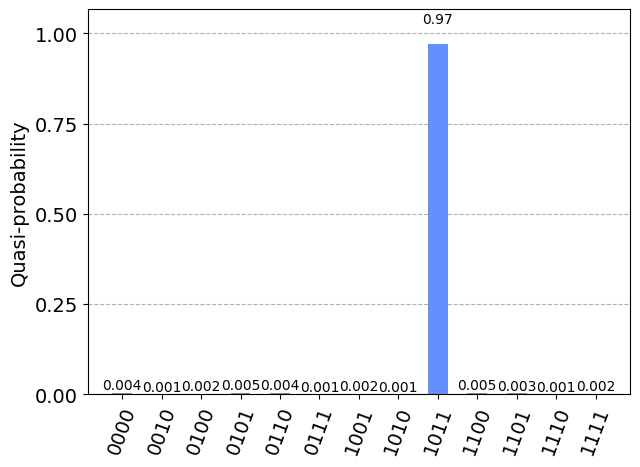

In [85]:
x = {'1011': 993, '1001': 2, '1100': 5, '0110': 4, '1111': 2, '1101': 3, '0000': 4, '0111': 1, '0101': 5, '0100': 2, '0010': 1, '1110': 1, '1010': 1}
x = {
    key : (100*value) / sum(x.values()) for key,value in x.items()
}
plot_histogram(x)

In [ ]:
# Sample that we entered an input value to the result parameters to save
qc_transpiled_list[60].backend_name

'fake_auckland'

In [ ]:
qc_res  = [
    qc_param.backend.run(qc_param.transpiled_qc,shots=1024)
    for qc_param in qc_transpiled_list
]

In [ ]:
qc_res_seed  = [
    qc_param.backend.run(qc_param.transpiled_qc,shots=1024, seed_simulator=seed)
    for qc_param in qc_transpiled_list
]

In [ ]:
len(qc_res)

224

In [ ]:
qc_resultData = [ResultData(res) for res in qc_res]

In [ ]:
qc_resultData_seed = [ResultData(res) for res in qc_res_seed]
x = [res.set_seed(seed) for res in qc_resultData_seed]

In [ ]:
len(qc_resultData)

224

In [ ]:
# excel_path = "../logs"
excel_name = "grover_results.csv"

save = CSVWriter(file_name=excel_name)

data = []
for qc_transpile, res_data, res_data_seed in zip(qc_transpiled_list, qc_resultData, qc_resultData_seed):
    data.append([qc_transpile, res_data])  
    data.append([qc_transpile, res_data_seed])  

save.save_data(data)

Data saved to ..\logs\grover_results_2024_08_09_22_03_54.csv


Running circuits for Grover with Unstructered list

In [70]:
backend_list = [FakeBackend('fake_auckland')]

In [71]:
# Sample of Finding a number in a list Grover circuit
max_value = 16
num_array = list(range(max_value))
random.shuffle(num_array)
experiments = {}

find_num_in_data = find_num_list()
# Create a random winner for the 16 length list
value = random.choice(num_array)
find_num_in_data.build_iteration(winner_list=[value], num_array=num_array, block_diagram=False, default_value=0)
find_num_in_data.create_grover(num_solutions=1, prep_value=[], block_diagram=False)
experiments[value] = {}
experiments[value]['circuit'] = find_num_in_data.measure_qc[0]
experiments[value]['additional'] = {'input_search' : value, 'input_num_array' : num_array}
# Remove barriars
for value in experiments:
    experiments[value]['circuit'] = RemoveBarriers()(experiments[value]['circuit'])

In [77]:
layout_list = [None] + list(permutations(range(len(data['circuit'].qubits)), len(data['circuit'].qubits)))
print(len(layout_list))

40321


In [84]:
length = 100
seed = 42

all_values_time = time.time()
for value, data in experiments.items():
    perm_index = 100
    while perm_index < len(layout_list):
        print(f"Start running circuit for perm {perm_index} to {perm_index + length}")
        perm_run_start_time = time.time()
        cur_layout_list = layout_list[perm_index : perm_index + length]
        qc_transpiled_list = []
        data_save = []
        #Transpiling circuits
        for index, layout in enumerate(cur_layout_list):    
            print(f"Transpliling circuit for layout {layout}")
            all_backend_run_time = time.time()
            for backend in backend_list:
                for opt_level in [0,3]:
                    opt_time = time.time()
                    qc_transpiled_list.append(backend.transpile_save_param(qc=data['circuit'], optimization_level=opt_level, initial_layout=layout, seed_transpiler=None, **data['additional']))
                    print(f"Finsihed transpiling backend {backend.get_backend().name} with opt {opt_level} for and layout {layout} {time.time() - opt_time} seconds")
            print(f"Finished Transpiling on backend {backend.get_backend().name} with layout {layout} indexed {index} in {time.time() - all_backend_run_time} seconds")  
        # Running circuits
        running_circuit_time = time.time()
        print(f"Running circuits and getting results")
        for index, qc in enumerate(qc_transpiled_list):
            for seed_val in [seed]:
                seed_run_time = time.time()
                qc_result = qc.backend.run(qc.transpiled_qc, shots = 1024, seed_simulator = seed_val)
                qc_result = ResultData(qc_result)
                qc_result.set_seed(seed_val)
                data_save.append([qc, qc_result])
                print(f"Finished running circuit indexed {index} out of {len(qc_transpiled_list)} with seed {seed_val} in {round(time.time() - seed_run_time,4)}  Seconds")
        print(f"Finished Running for Circuits : {time.time() - running_circuit_time} seconds")
        # Saving data
        additional_txt = f'_Perm_{perm_index}_{perm_index + length}'
        for key, value in data['additional'].items():
            additional_txt = additional_txt + f"_{key}_{value}"
        excel_name = f"grover_results{additional_txt}.csv"
        save = CSVWriter(file_name=excel_name, folder_path=r"..\logs\Grover_Data_list")
        save.save_data(data_save)
        print(f"Finished for perm {perm_index} -> {perm_index + length} in {time.time() - perm_run_start_time} seconds")
        perm_index = perm_index + length
print(f"Finished all circuits in {time.time() - all_values_time}")

Start running circuit for perm 100 to 200
Transpliling circuit for layout (0, 1, 2, 7, 3, 5, 6, 4)
Finsihed transpiling backend fake_auckland with opt 0 for and layout (0, 1, 2, 7, 3, 5, 6, 4) 15.326523303985596 seconds
Finsihed transpiling backend fake_auckland with opt 3 for and layout (0, 1, 2, 7, 3, 5, 6, 4) 18.366435527801514 seconds
Finished Transpiling on backend fake_auckland with layout (0, 1, 2, 7, 3, 5, 6, 4) indexed 0 in 33.69295883178711 seconds
Transpliling circuit for layout (0, 1, 2, 7, 3, 6, 4, 5)
Finsihed transpiling backend fake_auckland with opt 0 for and layout (0, 1, 2, 7, 3, 6, 4, 5) 7.1187450885772705 seconds
Finsihed transpiling backend fake_auckland with opt 3 for and layout (0, 1, 2, 7, 3, 6, 4, 5) 17.850104331970215 seconds
Finished Transpiling on backend fake_auckland with layout (0, 1, 2, 7, 3, 6, 4, 5) indexed 1 in 24.968849420547485 seconds
Transpliling circuit for layout (0, 1, 2, 7, 3, 6, 5, 4)
Finsihed transpiling backend fake_auckland with opt 0 for 

KeyboardInterrupt: 

Running circuits for diffrent Backends

In [18]:
# Create the list of backends
backend_list = [Backend()]

# Add fake backend
fakebackend_name_list = FakeBackend.get_ibm_fake_backend_names_with_limit(20, 30)
fakebakcend_list = [FakeBackend(fake_name) for fake_name in fakebackend_name_list]
backend_list = backend_list + fakebakcend_list

In [54]:
# Sample of Finding a number in a list Grover circuit
max_value = 16
num_array = list(range(max_value))
random.shuffle(num_array)
experiments = {}

find_num_in_data = find_num_list()
# Get circuits for each winner value
for value in num_array:
    find_num_in_data.build_iteration(winner_list=[value], num_array=num_array, block_diagram=False, default_value=0)
    find_num_in_data.create_grover(num_solutions=1, prep_value=[], block_diagram=False)
    experiments[value] = {}
    experiments[value]['circuit'] = find_num_in_data.measure_qc[0]
    experiments[value]['additional'] = {'input_search' : value, 'input_num_array' : num_array}
# Remove barriars
for value in experiments:
    experiments[value]['circuit'] = RemoveBarriers()(experiments[value]['circuit'])

In [ ]:
find_num_obj = find_num()
num_qubits = 6
experiments = {}
seed = 42

# Get circuits for each value
for value in range(2**num_qubits):
    find_num_obj.build_iteration(winner_num_list=[value], circuit_nqubits=num_qubits, block_diagram=False)
    find_num_obj.create_grover(num_solutions=1, prep_value=[], block_diagram=False)
    experiments[value] = {}
    experiments[value]['circuit'] = find_num_obj.measure_qc[0]
    experiments[value]['additional'] = {'input_search' : value, 'input_num_qubits' : num_qubits}
# Remove barriars
for value in experiments:
    experiments[value]['circuit'] = RemoveBarriers()(experiments[value]['circuit'])

In [56]:

all_values_time = time.time()
for value, data in experiments.items():
    value_start_time = time.time()
    qc_transpiled_list = []
    data_save = []
    start_time = time.time()
    print(f"Running circuit on searchable value {value}")
    for backend in backend_list:
        print(f"Value {value} : Running on backend {backend.get_backend().name}")
        for opt_level in [0,3]:
            opt_time = time.time()
            qc_transpiled_list.append(backend.transpile_save_param(qc=data['circuit'], optimization_level=opt_level, initial_layout=None, seed_transpiler=None, **data['additional']))
            print(f"Finsihed transpiling backend with opt {opt_level} for {time.time() - opt_time} seconds")
    print(f"Value {value} : Finished transpiling for all backend : {time.time() - start_time} seconds")
    start_time = time.time()
    for index, qc in enumerate(qc_transpiled_list):
        for seed_val in [seed]:
            start_time = time.time()
            qc_result = qc.backend.run(qc.transpiled_qc, shots = 1024, seed_simulator = seed_val)
            qc_result = ResultData(qc_result)
            qc_result.set_seed(seed_val)
            data_save.append([qc, qc_result])
            experiments[value]['count'] = qc_result.get_counts()
            experiments[value]['result_time'] = qc_result.get_result_time_taken()
            print(f"Finished running circuit indexed {index} out of {len(qc_transpiled_list)} with seed {seed_val} in {round(time.time() - start_time,4)}  Seconds")
    print(f"Value {value} : Finished Running for all backend : {time.time() - start_time} seconds")
    additional_txt = ''
    for key, value in data['additional'].items():
        additional_txt = additional_txt + f"_{key}_{value}"
    excel_name = f"grover_results{additional_txt}.csv"
    save = CSVWriter(file_name=excel_name, folder_path=r"..\logs\backends_log_B")
    save.save_data(data_save)
    print(f"Finished for value {value} in {time.time() - value_start_time} seconds")
print(f"Finished all circuits in {time.time() - all_values_time}")

Running circuit on searchable value 2
Value 2 : Running on backend aer_simulator
Finsihed transpiling backend with opt 0 for 0.47013211250305176 seconds
Finsihed transpiling backend with opt 3 for 3.0638132095336914 seconds
Value 2 : Running on backend fake_algiers
Finsihed transpiling backend with opt 0 for 5.856817245483398 seconds
Finsihed transpiling backend with opt 3 for 24.315541744232178 seconds
Value 2 : Running on backend fake_almaden
Finsihed transpiling backend with opt 0 for 4.863955020904541 seconds
Finsihed transpiling backend with opt 3 for 14.55326533317566 seconds
Value 2 : Running on backend fake_auckland
Finsihed transpiling backend with opt 0 for 6.106565237045288 seconds
Finsihed transpiling backend with opt 3 for 25.90986728668213 seconds
Value 2 : Running on backend fake_boeblingen
Finsihed transpiling backend with opt 0 for 4.156767845153809 seconds
Finsihed transpiling backend with opt 3 for 13.55717420578003 seconds
Value 2 : Running on backend fake_cairo
Fin